# **Bài Lab 2.2: Biến đổi góc nhìn từ trên (BEV)**

Trong bài lab này, bạn sẽ học cách biến đổi mask vạch làn từ góc nhìn của camera sang **góc nhìn từ trên (Bird's‑Eye View – BEV)**.
Bước này giúp chuẩn hóa phép đo hình học của làn đường.
Bạn sẽ sử dụng mask đã được tinh lọc từ Lab 2.1 làm đầu vào.


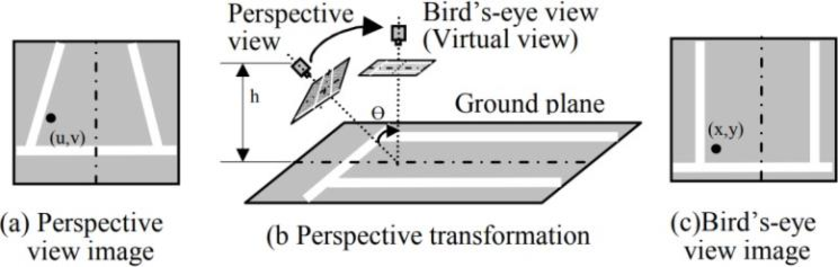

Hình trên mô tả cách một điểm trên ảnh camera (ảnh phối cảnh) được biến đổi để trở thành điểm tương ứng trong ảnh nhìn từ trên xuống (Bird’s-Eye View):

(a) Perspective view image:
Đây là ảnh gốc thu từ camera. Các lane xuất hiện dạng hình thang do hiệu ứng phối cảnh; các điểm xa bị thu nhỏ lại.

(b) Perspective transformation:
Ảnh phối cảnh được “trải phẳng” xuống mặt đất bằng phép biến đổi hình học (homography).
Camera đặt ở độ cao *h* và nghiêng một góc θ, tạo ra biến dạng mà BEV cố gắng loại bỏ.

(c) Bird’s-eye view image:
Sau khi biến đổi, lane trở thành hình chữ nhật với hai biên song song, giống như nhìn thẳng từ phía trên xuống.
Các điểm ảnh trong không gian BEV phản ánh đúng vị trí trên mặt đường hơn so với ảnh phối cảnh ban đầu.


![bird eye view .jpg](<attachment:bird eye view .jpg>)

Hình bên trên minh họa quá trình “trải phẳng” hình học: từ ảnh phối cảnh của camera (trái) sang ảnh đã được hiệu chỉnh (phải), nơi các đường thẳng trên mặt phẳng nền trở lại dạng song song đúng theo hình học thực.
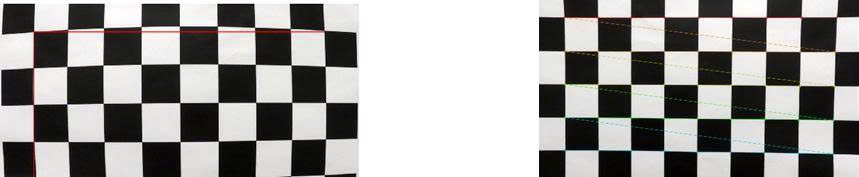

### **Task 1 – Import thư viện**
>Trong bước này, bạn cần khởi tạo các thư viện sẽ được sử dụng xuyên suốt Lab 2.2.
Các thư viện này phục vụ cho việc xử lý ảnh, tính toán hình học và trực quan hóa kết quả trong quá trình thực hiện BEV (Bird’s-Eye View) và các phép biến đổi hình học tiếp theo.

- NumPy (np): thao tác trên ma trận/tensor, tính toán số học cho các điểm ảnh và phép biến đổi không gian.

- OpenCV (cv2): đọc và xử lý ảnh, tạo ma trận homography, warp ảnh sang không gian BEV.

- Matplotlib (plt): hiển thị ảnh đầu vào, ảnh sau biến đổi BEV và các bước trung gian để kiểm chứng trực quan.

Chạy cell dưới đây để đảm bảo môi trường sẵn sàng trước khi tiến vào phần BEV Transformation.


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

### **Task 2 – Đọc mask làn đường đã tinh chỉnh**

>Task này giúp bạn nạp lại mặt nạ đã được refine ở Lab 2.1, chuyển sang dạng nhị phân (0–1) và kiểm tra xem file load đã đúng chưa trước khi thực hiện BEV Transformation ở bước tiếp theo.

1) mask_path = '...'

   - Bạn cần nhập đường dẫn đến file mask đã được refine ở Lab 2.1.
   - Nếu bạn dùng code lưu tự động, file thường nằm trong thư mục result_refine/.

2) cv2.imread(..., cv2.IMREAD_GRAYSCALE)

   - Mask refine chỉ cần 1 kênh (grayscale).
   - Không đọc RGB để tránh thừa dữ liệu.

3) Kiểm tra mask_img is None

   - Nếu đường dẫn sai → cv2.imread trả về None.
   - Đây là lỗi phổ biến khi sinh viên quên di chuyển file vào đúng folder.

4) (mask_img > 0).astype(np.uint8)

   - Giúp chuẩn hóa mask về 0 hoặc 1.
   - Đây là dạng cần thiết cho BEV và cho mọi phép đo hình học trong pipeline.

5) plt.imshow(mask01, cmap='gray')

   - Kiểm tra nhanh mask đã được load đúng chưa trước khi sang bước chuyển BEV.


In [ ]:
# TODO: Thay đường dẫn tới file mask sau bước refine ở Lab 2.1
mask_path = '...'        # ví dụ: 'result_refine/refined_12345.png'

# Đọc mask ở chế độ grayscale
mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# TODO: Kiểm tra mask_img có đọc được hay không (gợi ý: if mask_img is None: ...)
# ...

# TODO: Chuyển thành mask nhị phân (0 hoặc 1)
mask01 = (... > 0).astype(np.uint8)

# Hiển thị mask để kiểm tra
plt.figure(figsize=(4, 4))
plt.title('Mask sau khi refine')
plt.imshow(mask01, cmap='gray')
plt.axis('off')
plt.show()


### **Task 3 – Tính ma trận biến đổi phối cảnh**

### 1. Tọa độ chuẩn hóa (ratio):

Thay vì lưu trực tiếp theo pixel, ta lưu mỗi điểm dưới dạng tỷ lệ theo chiều rộng / chiều cao:

$$
x_{\text{ratio}} = \frac{x_{\text{pix}}}{W}, \quad
y_{\text{ratio}} = \frac{y_{\text{pix}}}{H}
$$

Khi đó:

$$
x_{\text{pix}} = x_{\text{ratio}} \cdot W,\quad
y_{\text{pix}} = y_{\text{ratio}} \cdot H
$$

**Ưu điểm:**

- Ảnh có độ phân giải khác nhau nhưng cùng `SRC_RATIOS` vẫn cho ra vùng BEV tương tự.  
- Dễ tái sử dụng trong nhiều hệ thống / dataset.

### 2. Ý nghĩa `SRC_RATIOS` và `DST_RATIOS`

- `SRC_RATIOS` là 4 điểm trên mặt nạ gốc (view của camera): thường là đỉnh của một hình thang ôm trọn làn đường.  
- `DST_RATIOS` là 4 điểm tương ứng trên mặt phẳng BEV: thường là 4 góc của hình chữ nhật.

Bạn có thể hình dung bằng bảng:

| Điểm | Nguồn (`SRC_RATIOS`) | Đích (`DST_RATIOS`) | Ý nghĩa ngắn gọn |
|------|----------------------|----------------------|------------------|
| P1   | (0.20, 0.58)         | (0.25, 0.00)         | Mép trái gần camera → mép trái phía trên trong BEV |
| P2   | (0.10, 0.90)         | (0.25, 1.00)         | Mép trái xa camera → mép trái phía dưới trong BEV  |
| P3   | (0.90, 0.90)         | (0.75, 1.00)         | Mép phải xa camera → mép phải phía dưới trong BEV  |
| P4   | (0.80, 0.58)         | (0.75, 0.00)         | Mép phải gần camera → mép phải phía trên trong BEV |

- Ở ảnh gốc, 4 điểm tạo thành **hình thang** (do hiệu ứng phối cảnh).  
- Ở BEV, 4 điểm được đưa về **hình chữ nhật** (hai mép lane song song).

Đó chính là mục tiêu của ma trận homography.


### 3. Từ ratio sang pixel: `src_pts`, `dst_pts`

Đoạn code:

```python
H, W = mask01.shape
src_pts = SRC_RATIOS * np.array([W, H], dtype=np.float32)
dst_pts = DST_RATIOS * np.array([W, H], dtype=np.float32)



Tương ứng với công thức:
$$[x_{\text{pix}} \ y_{\text{pix}}] = [x_{\text{ratio}} \ y_{\text{ratio}}] \odot [W \ H]$$

trong đó ký hiệu $(\odot)$ là phép nhân từng phần tử (element-wise).

**Kết quả:**

- `src_pts`: mảng (4, 2) chứa tọa độ pixel của 4 điểm nguồn.  
- `dst_pts`: mảng (4, 2) chứa tọa độ pixel của 4 điểm đích.


### 4. Tính ma trận biến đổi phối cảnh \(M\)

OpenCV cung cấp hàm:

```python
M = cv2.getPerspectiveTransform(src_pts, dst_pts)


Hàm này trả về ma trận homography 3×3:

$$
M = \begin{bmatrix}
m_{11} & m_{12} & m_{13} \\
m_{21} & m_{22} & m_{23} \\
m_{31} & m_{32} & m_{33}
\end{bmatrix}
$$

Mỗi điểm nguồn $(x,y)$ được chiếu sang điểm đích $(𝑥',𝑦')$ theo:

$$
\begin{bmatrix}
x' \\
y' \\
w
\end{bmatrix}
= M
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix},
\quad x_{\text{dst}} = \frac{x'}{w},
\quad y_{\text{dst}} = \frac{y'}{w}
$$

Khi áp dụng:
bev_mask = cv2.warpPerspective(mask01, M, (W, H))

→ Vùng hình thang của làn đường sẽ trở thành hình chữ nhật nhìn từ trên xuống (BEV).

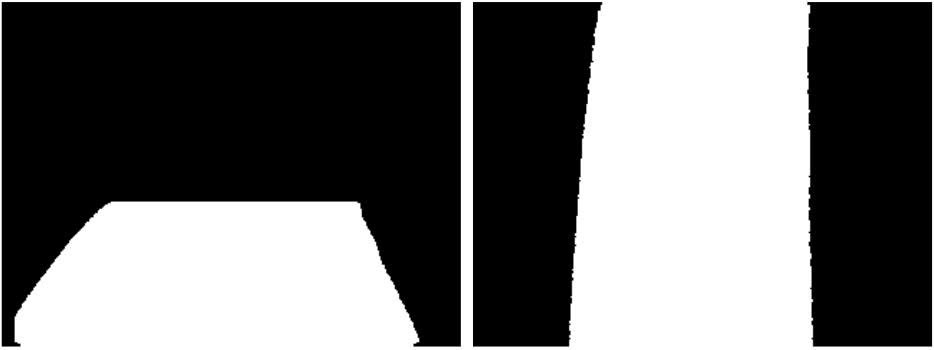

In [ ]:
# TODO: Định nghĩa tỷ lệ nguồn và đích (tọa độ chuẩn hóa)
# Gợi ý: nhập 4 điểm ratio dạng (x_ratio, y_ratio)
SRC_RATIOS = np.float32([..., ..., ..., ...])   # ví dụ: (0.20, 0.58)

DST_RATIOS = np.float32([..., ..., ..., ...])       # ví dụ: (0.25, 0.00)


# TODO: Tính tọa độ pixel từ tỷ lệ
# Gợi ý: dùng mask01.shape để lấy H, W
H, W = ...

# Gợi ý: nhân SRC_RATIOS và DST_RATIOS với [W, H] để ra pixel
src_pts = ... * np.array([W, H], dtype=np.float32)
dst_pts = ... * np.array([W, H], dtype=np.float32)


# TODO: Tính ma trận biến đổi phối cảnh (homography)
M = cv2.getPerspectiveTransform(..., ...)


#### Ánh xạ mask sang không gian BEV

Sau khi đã tính được ma trận homography 𝑀, ta có thể “trải phẳng” mask từ ảnh phối cảnh sang không gian nhìn từ trên xuống (BEV) bằng hàm:
cv2.warpPerspective(...) 


In [ ]:
# TODO: Thực hiện biến đổi mask sang không gian BEV
bev = ...

# TODO: Chuyển kết quả warp về dạng mask nhị phân (0/1)
bev_mask = ...


### **Task 4 – Hiển thị kết quả BEV**

Hiển thị song song mask ban đầu (đã refine) và mask sau khi biến đổi sang BEV bằng Matplotlib.
Điều này giúp bạn kiểm tra xem phép biến đổi có đúng hay không và vùng làn đường đã được ánh xạ chính xác vào hình chữ nhật BEV.


In [ ]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title('Mask sau refine')
plt.imshow(mask01, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Mask BEV')
plt.imshow(bev_mask, cmap='gray')
plt.axis('off')

plt.show()
